In [6]:
import sys
from pathlib import Path

# Add project root to PYTHONPATH
ROOT = Path("..").resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

print(sys.executable)
    
print("Project root in sys.path:", ROOT)

C:\Users\Alessio\anaconda3\envs\portfolio_env\python.exe
Project root in sys.path: C:\Users\Alessio\Desktop\Portfolio_data_analysis\satellite_data_analysis


In [7]:
import numpy as np
import random
import joblib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from src.preprocessing import (
    load_clean_data,
    prepare_classification_data,
)
from src.features import build_preprocessor
from src.preprocessing import get_classification_feature_columns

In [8]:
from pathlib import Path

DB_PATH = Path("../data/processed/satellites.db")

# Load clean table
df = load_clean_data(DB_PATH, table_name="satellites_clean")
df.head()

,norad_id,name,object_type,satellite_constellation,altitude_km,altitude_category,orbital_band,congestion_risk,inclination,eccentricity,launch_year_estimate,days_in_orbit_estimate,orbit_lifetime_category,mean_motion,epoch,data_source,snapshot_date,country,last_seen,period_minutes
0,900,CALSPHERE 1,PAYLOAD,Other,976.884937,Low LEO,LEO-Polar,LOW,90.2215,0.002694,2023,0,<1yr,13.763434,2025-12-01 05:13:21.035712,celestrak,2025-12-01,US,2025-12-01,104.625052
1,902,CALSPHERE 2,PAYLOAD,Other,1061.676342,Mid LEO,LEO-Polar,LOW,90.2363,0.002049,2023,0,<1yr,13.528813,2025-12-01 08:07:51.479328,celestrak,2025-12-01,US,2025-12-01,106.439491
2,1361,LCS 1,PAYLOAD,Other,2787.875054,High LEO,MEO,LOW,32.1433,0.001342,2023,0,<1yr,9.893094,2025-12-01 06:07:31.789920,celestrak,2025-12-01,US,2025-12-01,145.556085
3,1512,TEMPSAT 1,PAYLOAD,Other,1133.287003,Mid LEO,LEO-Polar,HIGH,89.9889,0.007145,2023,0,<1yr,13.335808,2025-12-01 10:59:03.479424,celestrak,2025-12-01,US,2025-12-01,107.979956
4,1520,CALSPHERE 4A,PAYLOAD,Other,1123.333009,Mid LEO,LEO-Polar,HIGH,89.9090,0.006829,2023,0,<1yr,13.362361,2025-12-01 11:13:16.955040,celestrak,2025-12-01,US,2025-12-01,107.765388


In [9]:
# Prepare X and y
X, y = prepare_classification_data(df)
num_cols, cat_cols = get_classification_feature_columns()

print("Shape X:", X.shape)
print("Distribuzione target:")
print(y.value_counts(normalize=True))

Shape X: (13088, 9)
Distribuzione target:
orbital_band
LEO-Inclined      0.446898
LEO-Equatorial    0.261996
LEO-Polar         0.228606
GEO               0.034765
MEO               0.020171
GEO-Inclined      0.004814
HEO               0.002139
LEO-Retrograde    0.000611
Name: proportion, dtype: float64


In [10]:
#Define seed for the best reproducibility
SEED = 42

np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

X_train, X_val, y_train_labels, y_val_labels = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y,
)

print("Train shape:", X_train.shape, "Val shape:", X_val.shape)

Train shape: (10470, 9) Val shape: (2618, 9)


In [11]:
# Encoding labels to integers
class_labels, y_train_int = np.unique(y_train_labels, return_inverse=True)
label_to_index = {label: idx for idx, label in enumerate(class_labels)}
n_classes = len(class_labels)

y_val_int = np.array([label_to_index[label] for label in y_val_labels])

print("Class labels:", class_labels)
print("Num classes:", n_classes)

Class labels: ['GEO' 'GEO-Inclined' 'HEO' 'LEO-Equatorial' 'LEO-Inclined' 'LEO-Polar'
 'LEO-Retrograde' 'MEO']
Num classes: 8


In [12]:
from src.features import build_preprocessor

preprocessor = build_preprocessor(num_cols, cat_cols)

# Fit on training data
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)

# Convert to dense arrays
if hasattr(X_train_proc, "toarray"):
    X_train_proc = X_train_proc.toarray()
    X_val_proc = X_val_proc.toarray()

X_train_proc = X_train_proc.astype("float32")
X_val_proc = X_val_proc.astype("float32")

X_train_proc.shape, X_val_proc.shape

((10470, 105), (2618, 105))

In [13]:
input_dim = X_train_proc.shape[1]
display(input_dim)

model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(n_classes, activation="softmax"),
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

105



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                6784      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
Total params: 9128 (35.66 KB)
Trainable params: 9128 (35.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
    )
]

history = model.fit(
    X_train_proc,
    y_train_int,
    validation_data=(X_val_proc, y_val_int),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/50


164/164 [==============================] - 1s 5ms/step - loss: 0.8646 - accuracy: 0.6842 - val_loss: 0.3816 - val_accuracy: 0.9622
Epoch 2/50
164/164 [==============================] - 0s 3ms/step - loss: 0.2133 - accuracy: 0.9739 - val_loss: 0.1328 - val_accuracy: 0.9763
Epoch 3/50
164/164 [==============================] - 0s 3ms/step - loss: 0.0995 - accuracy: 0.9804 - val_loss: 0.0932 - val_accuracy: 0.9775
Epoch 4/50
164/164 [==============================] - 0s 3ms/step - loss: 0.0743 - accuracy: 0.9830 - val_loss: 0.0754 - val_accuracy: 0.9805
Epoch 5/50
164/164 [==============================] - 0s 3ms/step - loss: 0.0617 - accuracy: 0.9842 - val_loss: 0.0714 - val_accuracy: 0.9805
Epoch 6/50
164/164 [==============================] - 1s 3ms/step - loss: 0.0537 - accuracy: 0.9852 - val_loss: 0.0616 - val_accuracy: 0.9813
Epoch 7/50
164/164 [==============================] - 0s 3ms/step - loss: 0.0497 - accuracy: 0.9847 - val_loss: 0.0626 - val_accuracy: 0.9813
Epoc

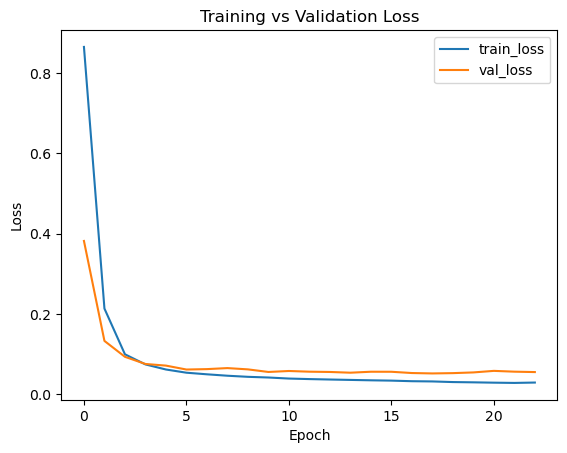

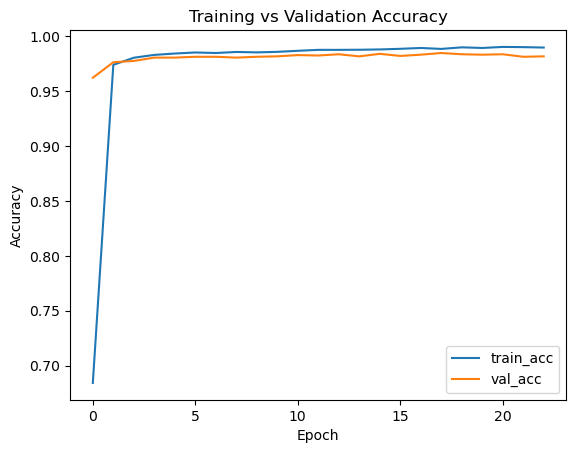

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss");

plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy");

In [16]:
# Numerical Evaluation
val_loss, val_acc = model.evaluate(X_val_proc, y_val_int, verbose=0)
print(f"Validation loss: {val_loss:.4f}")
print(f"Validation accuracy: {val_acc:.4f}")

Validation loss: 0.0519
Validation accuracy: 0.9847


In [17]:
# Predictions and report
y_val_pred_proba = model.predict(X_val_proc)
y_val_pred_int = y_val_pred_proba.argmax(axis=1)

# Convert predicted labels into the original string
y_val_pred_labels = class_labels[y_val_pred_int]
y_val_true_labels = y_val_labels.to_numpy()

print(classification_report(y_val_true_labels, y_val_pred_labels))
print("Confusion matrix:\n", confusion_matrix(y_val_true_labels, y_val_pred_labels))

82/82 [==============================] - 0s 1ms/step
                precision    recall  f1-score   support

           GEO       0.86      0.98      0.91        91
  GEO-Inclined       0.53      0.69      0.60        13
           HEO       0.67      1.00      0.80         6
LEO-Equatorial       1.00      0.99      0.99       686
  LEO-Inclined       1.00      1.00      1.00      1170
     LEO-Polar       1.00      1.00      1.00       598
LEO-Retrograde       0.00      0.00      0.00         1
           MEO       0.86      0.60      0.71        53

      accuracy                           0.98      2618
     macro avg       0.74      0.78      0.75      2618
  weighted avg       0.99      0.98      0.98      2618

Confusion matrix:
 [[  89    2    0    0    0    0    0    0]
 [   3    9    0    0    0    0    0    1]
 [   0    0    6    0    0    0    0    0]
 [   1    2    0  679    4    0    0    0]
 [   0    0    0    1 1166    0    0    3]
 [   0    0    0    0    0  597    0  

C:\Users\Alessio\anaconda3\envs\portfolio_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Alessio\anaconda3\envs\portfolio_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Alessio\anaconda3\envs\portfolio_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

In [18]:
from pathlib import Path

MODELS_KERAS_DIR = Path("../models/keras")
MODELS_KERAS_DIR.mkdir(parents=True, exist_ok=True)

# Keras model
model.save(MODELS_KERAS_DIR / "keras_classification_model.h5")

# sklearn preprocessor
joblib.dump(preprocessor, MODELS_KERAS_DIR / "preprocessor.joblib")

# Map class
np.save(MODELS_KERAS_DIR / "class_labels.npy", class_labels)

print("Saved Keras model and preprocessing artifacts in:", MODELS_KERAS_DIR)

Saved Keras model and preprocessing artifacts in: ..\models\keras


C:\Users\Alessio\anaconda3\envs\portfolio_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
